In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import pandas as pd
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

from datetime import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
folders=os.listdir( '245_data')
print(folders)

['phi', 'q', 'gt', 'theta', 'sin', 'div', 'cos', 'G', 'T', 'j', 'f', 'u', '!', 'times', 'C', '8', 'pm', 'forward_slash', 'p', 'log', ']', 'sum', 'N', '5', 'Delta', 'H', 'tan', 'S', 'prime', 'ldots', 'rightarrow', 'neq', '-', 'M', 'A', 'e', 'l', 'gamma', 'exists', 'k', '4', ',', 'in', 'pi', '=', '0', '3', 'leq', 'd', '+', 'alpha', '1', 'X', 'lim', '{', '7', 'lambda', '}', 'ascii_124', 'beta', 'mu', 'forall', 'sigma', '9', 'o', '2', 'b', 'R', 'geq', 'y', 'w', '[', '(', 'lt', ')', 'z', '6', 'sqrt', 'infty', 'v', 'int', 'i']


In [3]:
import cv2
from matplotlib import pyplot as plt

if os.path.exists('245_data.csv'):
    df = pd.read_csv('245_data.csv', low_memory=False)
    del df['Unnamed: 0']
else:
    data = []
    label = []

    for each in folders:
        print(each)
        file_ct=0
        currentFolder = '245_data/' + each
        for i, file in enumerate(os.listdir(currentFolder)):
            if file_ct > 1000:
                break
            im= cv2.imread((os.path.join(currentFolder, file)))
            img=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
            #resize
            img = 255 - img
            img = cv2.resize(img, (16, 16), interpolation=cv2.INTER_AREA)
            img[img < 10] = 0
            img[img >= 10] = 1
#             print(img)
            
#             plt.imshow(img)
#             plt.show()
#             raise Exception()
        
            img = img.ravel()
            img = img.tolist()
        
            data.append(img)
            label.append(each)
            file_ct+=1

    df = pd.DataFrame(data)
    df["label"] = label
    df.to_csv('245_data.csv')

df.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,label
0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,phi
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,phi
2,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,phi
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,phi
4,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,phi


In [4]:
df.shape

(67640, 257)

In [5]:
numeric_data=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
alpha_data=['A', 'b','C','d', 'e', 'f', 'G', 'H', 'i', 'j', 'k', 'l', 'M', 'mu', 'N','o', 'p','q', 'R','S','T', 'u', 'v', 'w', 'X', 'y', 'z']
symbol_data=['!', '(', ')', '+', ',', '-','=','alpha', 'ascii_124', 'beta', 'cos', 'Delta', 'div','exists', 'forall', 'forward_slash','gamma', 'geq', 'gt', 'in', 'infty', 'int','lambda', 'ldots', 'leq', 'lim', 'log', 'lt','mu', 'neq', 'phi', 'pi', 'pm', 'prime', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', '[', ']', '{', '}']

EDA

Text(0, 0.5, 'Count')

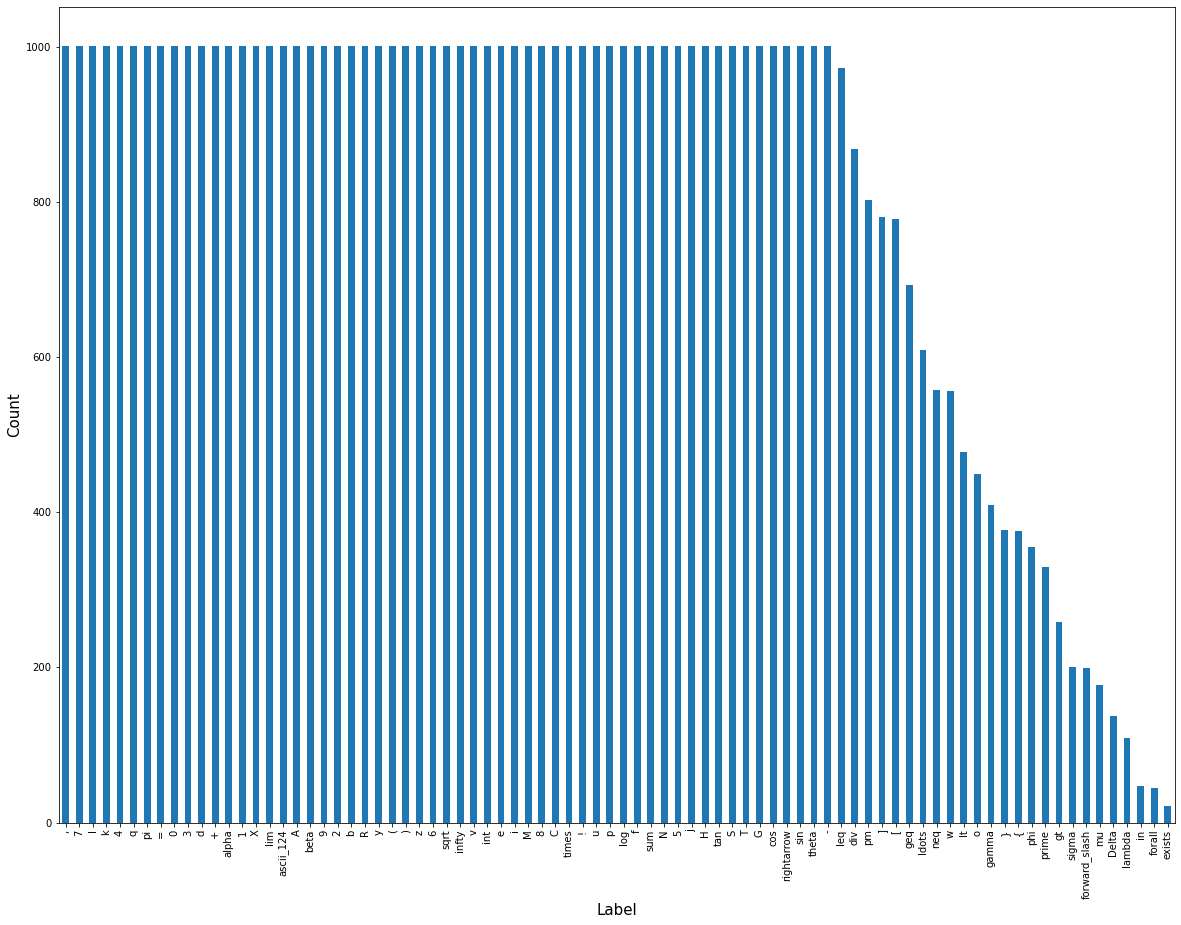

In [6]:
plt.figure(figsize=(20,15))
pd.value_counts(df['label']).plot.bar()
plt.xlabel('Label', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

In [7]:
#original image instance
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
i=0
original_image=[]
path = r'245_data/1/1_2.jpg'
im= cv2.imread(path)
img=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
original_image.append(img_to_array(img))


#processed image instance
processed_image=[]
im= cv2.imread(path)
img=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
resized_image = cv2.resize(img, (8,8))   
resized_image = resized_image.astype('float32') / 255
processed_image.append(img_to_array(resized_image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


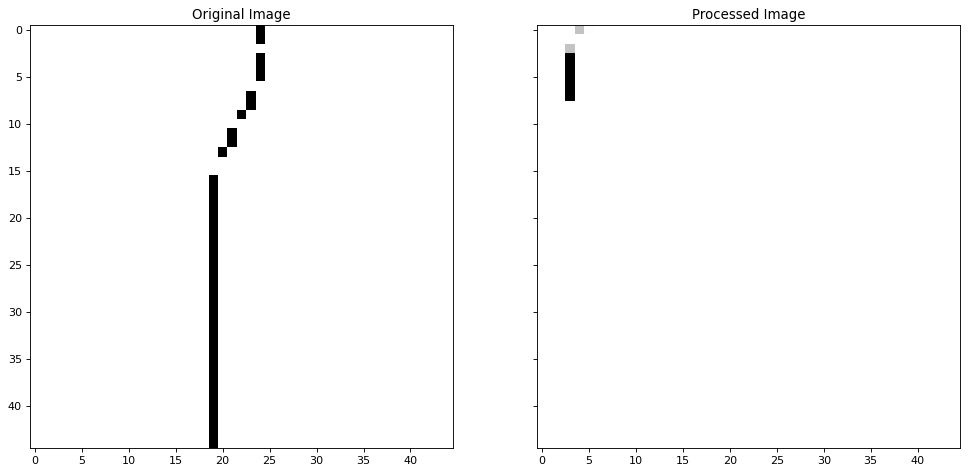

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), dpi=80, sharex=True, sharey=True)


ax[1].imshow(np.squeeze(processed_image),cmap='gray')
ax[0].imshow(np.squeeze(original_image))

ax[0].title.set_text('Original Image')
ax[1].title.set_text('Processed Image')

Prepare dataset to train

In [9]:
#remove outlier
df1 = df[df.groupby(['label'])['label'].transform('count') > 500]
df1.shape

(63674, 257)

In [10]:
len(set(df1.label))

66

In [11]:
data=df1.iloc[:,:-1]
label=df1.iloc[:,-1]

from sklearn.preprocessing import LabelEncoder
label_encoded = LabelEncoder().fit_transform(label)
df1['label'] = label_encoded

#60% train, 20% test, 20% validation
train, test = train_test_split(df1, test_size=0.2, random_state=22, shuffle=True)
train, val = train_test_split(train, test_size=0.25, random_state=22)

/tmp/ipykernel_66603/1237765912.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['label'] = label_encoded


In [12]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,label
44006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
59889,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2
9430,0,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,37
5356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,33
19582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22


In [13]:
def balance(df):
    groupby = df.groupby('label')
    df = groupby.apply(lambda x: x.sample(groupby.size().max(), replace=True).reset_index(drop=True))
    del df['label']
    df = df.reset_index()
    del df['level_1']
    df = df.sample(frac=1)
    return df

train = balance(train)

print(f'train: {len(train)}, validation: {len(val)}, test: {len(test)}')

train: 42240, validation: 12735, test: 12735


In [14]:
train.head()

,label,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
31611,49,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
14370,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2499,3,0,0,0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
264,0,0,0,0,0,0,0,0,1,1,...,0,1,1,0,0,0,0,0,0,0
30921,48,0,0,0,0,1,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [15]:
train.groupby('label')['label'].count()

label
0     640
1     640
2     640
3     640
4     640
     ... 
61    640
62    640
63    640
64    640
65    640
Name: label, Length: 66, dtype: int64

In [16]:
y_train = train['label'].to_numpy()
del train['label']
X_train = train.to_numpy()

y_val = val['label'].to_numpy()
del val['label']
X_val = val.to_numpy()

y_test = test['label'].to_numpy()
del test['label']
X_test = test.to_numpy()

In [17]:
print('Training dataset contains: ', X_train.shape, ' data')
print('Testing dataset contains: ', X_test.shape, ' data')
print('Validation dataset contains: ', X_val.shape, ' data')

Training dataset contains:  (42240, 256)  data
Testing dataset contains:  (12735, 256)  data
Validation dataset contains:  (12735, 256)  data


In [18]:
def svm_model(X_train, X_test, y_train, y_test):
    from sklearn import svm
    train_start = dt.now()
    svm_classifier = svm.SVC(kernel='rbf',gamma=0.001,C=5, max_iter=1000)
    svm_classifier.fit(X_train, y_train)
    traing_time = (train_start.now() - train_start).seconds
    
    predict_start=dt.now()
    y_pred = svm_classifier.predict(X_test)
    predict_time = (predict_start.now() - predict_start).seconds
    
    accuracy = accuracy_score(y_test,y_pred)*100
    
    performance_result.append(['SVM',traing_time,predict_time,accuracy])
    
    #print(confusion_matrix(y_test, y_pred))
    #print(classification_report(y_test, y_pred))

def linear_svm_model(X_train, X_test, y_train, y_test):
    from sklearn import svm
    train_start = dt.now()
    svm_classifier = svm.LinearSVC(max_iter=1000)
    svm_classifier.fit(X_train, y_train)
    traing_time = (train_start.now() - train_start).seconds
    
    predict_start=dt.now()
    y_pred = svm_classifier.predict(X_test)
    predict_time = (predict_start.now() - predict_start).seconds
    
    accuracy = accuracy_score(y_test,y_pred)*100
    
    performance_result.append(['LinearSVM',traing_time,predict_time,accuracy])
    
    #print(confusion_matrix(y_test, y_pred))
    #print(classification_report(y_test, y_pred))
    
def gaussian_naive_bayes(X_train, X_test, y_train, y_test):
    from sklearn.naive_bayes import GaussianNB
    
    train_start = dt.now()
    GNB_classifier = GaussianNB()
    GNB_classifier.fit(X_train, y_train)
    traing_time = (train_start.now() - train_start).seconds
    
    predict_start=dt.now()
    y_pred = GNB_classifier.predict(X_test)
    predict_time = (predict_start.now() - predict_start).seconds
    accuracy = accuracy_score(y_test,y_pred)*100
    
    performance_result.append(['NB',traing_time,predict_time,accuracy])

def decision_tree(X_train, X_test, y_train, y_test):
    from sklearn import tree
    
    train_start = dt.now()
    dt_classifier = tree.DecisionTreeClassifier()
    dt_classifier.fit(X_train, y_train)
    traing_time = (train_start.now() - train_start).seconds
    
    predict_start=dt.now()
    y_pred = dt_classifier.predict(X_test)
    predict_time = (predict_start.now() - predict_start).seconds
    accuracy = accuracy_score(y_test,y_pred)*100
    
    performance_result.append(['DT',traing_time,predict_time,accuracy])

def random_forest(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestClassifier
    
    train_start = dt.now()
    RF_classifier = RandomForestClassifier(max_depth=10, random_state=0)
    RF_classifier.fit(X_train, y_train)
    traing_time = (train_start.now() - train_start).seconds
    
    predict_start=dt.now()
    y_pred = RF_classifier.predict(X_test)
    predict_time = (predict_start.now() - predict_start).seconds
    accuracy = accuracy_score(y_test,y_pred)*100
    
    performance_result.append(['RF',traing_time,predict_time,accuracy])

def k_nearest_neighbors(X_train, X_test, y_train, y_test):
    from sklearn.neighbors import KNeighborsClassifier
    
    train_start = dt.now()
    KNN_classifier = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
    KNN_classifier.fit(X_train, y_train)
    traing_time = (train_start.now() - train_start).seconds
    
    predict_start=dt.now()
    y_pred = KNN_classifier.predict(X_test)
    predict_time = (predict_start.now() - predict_start).seconds
    accuracy = accuracy_score(y_test,y_pred)*100
    
    performance_result.append(['KNN',traing_time,predict_time,accuracy])

def stochastic_gradient_decend(X_train, X_test, y_train, y_test):
    from sklearn.linear_model import SGDClassifier
    
    train_start = dt.now()
    sgd_classifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=100)
    sgd_classifier.fit(X_train, y_train)
    traing_time = (train_start.now() - train_start).seconds
    
    predict_start=dt.now()
    y_pred = sgd_classifier.predict(X_test)
    predict_time = (predict_start.now() - predict_start).seconds
    accuracy = accuracy_score(y_test,y_pred)*100
    
    performance_result.append(['GD',traing_time,predict_time,accuracy])

In [32]:
import sklearn.metrics as metrics

evaluation_col = ["Model","training duration", "predicting duration", "accuracy score"]
performance_result=[]

from joblib import parallel_backend

with parallel_backend('threading', n_jobs=12):
    print('svm_model')
    svm_model(X_train, X_test, y_train, y_test)
    
    print('linear_svm_model')
    linear_svm_model(X_train, X_test, y_train, y_test)

    print('gaussian_naive_bayes')
    gaussian_naive_bayes(X_train, X_test, y_train, y_test)

    print('decision_tree')
    decision_tree(X_train, X_test, y_train, y_test)

    print('random_forest')
    random_forest(X_train, X_test, y_train, y_test)

    print('k_nearest_neighbors')
    k_nearest_neighbors(X_train, X_test, y_train, y_test)

    print('stochastic_gradient_decend')
    stochastic_gradient_decend(X_train, X_test, y_train, y_test)

svm_model
linear_svm_model


/home/zyan/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


gaussian_naive_bayes
decision_tree
random_forest
k_nearest_neighbors
stochastic_gradient_decend


In [33]:
eva_df = pd.DataFrame(performance_result, columns=evaluation_col)
eva_df

,Model,training duration,predicting duration,accuracy score
0,SVM,38,111,77.872006
1,LinearSVM,26,0,69.619160
2,NB,0,0,28.292108
3,DT,1,0,68.786808
4,RF,0,0,68.032980
5,KNN,0,9,71.880644
6,GD,4,0,67.098547


KNN + SVM

In [19]:
import numpy as np
import faiss


class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.copy(order='C').astype(np.float32))
        self.y = y

    def predict(self, X, k=None):
        X = X.copy(order='C')
        k = k or self.k
        distances, indices = self.index.search(X.astype(np.float32), k=k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions
    
    def kneighbors(self, X, n_neighbors):
        X = X.copy(order='C')
        return self.index.search(X.astype(np.float32), k=n_neighbors)

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

knn = FaissKNeighbors(k=5)
knn.fit(X_train, y_train)
for k in range(1, 20):
    y_pred = knn.predict(X_test, k)
    print(f'k: {k}, {accuracy_score(y_test,y_pred)*100}')

k: 1, 80.85590891244601
k: 2, 75.82253631723597
k: 3, 74.79387514723203
k: 4, 72.25755791126815
k: 5, 71.68433451118965
k: 6, 70.20023557126031
k: 7, 69.67412642324304
k: 8, 68.55908912446014
k: 9, 67.97016097369453
k: 10, 67.24774244208874
k: 11, 66.91009030231645
k: 12, 66.26619552414606
k: 13, 65.81861012956419
k: 14, 65.22968197879858
k: 15, 64.81350608559089
k: 16, 64.51511582253632
k: 17, 64.41303494307029
k: 18, 63.85551629367884
k: 19, 63.34511189634865


In [22]:
# num of classes based

from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

n_classes = len(set(df1.label))

def transform_X(X, y, n_neighbors):
    # neigh_dist, neigh_ind
    distances, indices = knn.kneighbors(X, n_neighbors=n_neighbors)
    votes = y[indices]
    X_transform = [np.bincount(x, minlength=n_classes) for x in votes]
    return np.vstack(X_transform)

for n_neighbors in range(2, 9):
    print(f'n_neighbors: {n_neighbors}, transforming X_train')
    X_train_svm = transform_X(X_train, y_train, n_neighbors)
    
    print(f'n_neighbors: {n_neighbors}, transforming X_test')
    X_test_svm = transform_X(X_test, y_train, n_neighbors)

    for max_iter in [2000]:
        print(f'max_iter: {max_iter}, training SVM')
        train_start = dt.now()
        svm = make_pipeline(StandardScaler(), SVC(max_iter=max_iter, tol=1e-5))
        svm.fit(X_train_svm, y_train)
        traing_time = (train_start.now() - train_start).seconds
        print(f'traing_time: {traing_time}')

        score_start = dt.now()
        accuracy = svm.score(X_test_svm, y_test)
        score_time = (score_start.now() - score_start).seconds
        print(f'accuracy: {accuracy}, time: {score_time}')

n_neighbors: 2, transforming X_train
n_neighbors: 2, transforming X_test
max_iter: 2000, training SVM
traing_time: 3
accuracy: 0.8043188064389478, time: 3
n_neighbors: 3, transforming X_train
n_neighbors: 3, transforming X_test
max_iter: 2000, training SVM
traing_time: 4
accuracy: 0.787122104436592, time: 5
n_neighbors: 4, transforming X_train
n_neighbors: 4, transforming X_test
max_iter: 2000, training SVM
traing_time: 4
accuracy: 0.7725952100510405, time: 6
n_neighbors: 5, transforming X_train
n_neighbors: 5, transforming X_test
max_iter: 2000, training SVM
traing_time: 5
accuracy: 0.7724381625441696, time: 8
n_neighbors: 6, transforming X_train
n_neighbors: 6, transforming X_test
max_iter: 2000, training SVM
traing_time: 6
accuracy: 0.7670200235571261, time: 10
n_neighbors: 7, transforming X_train
n_neighbors: 7, transforming X_test
max_iter: 2000, training SVM
traing_time: 6
accuracy: 0.7630938358853553, time: 11
n_neighbors: 8, transforming X_train
n_neighbors: 8, transforming X_t

In [ ]:
n_classes = len(set(df1.label))

svms = []
classes = []
for i in range(n_classes):
    svms.append([None for _ in range(n_classes)])
    classes.append([None for _ in range(n_classes)])

In [ ]:
# num of classes based

from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

def get_svm(i, j):
    assert i != j
    if i > j:
        i, j = j, i
    if svms[i][j] is not None:
        return svms[i][j]
    print(f'training {i}, {j}')
    train_start = dt.now()
    svm = make_pipeline(StandardScaler(), SVC(max_iter=1000, tol=1e-5))
    idx = (y_train == i).any() & (y_train == j).any()
    X_curt = X_train[idx].squeeze()
    y_curt = y_train[idx].squeeze()
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_curt = le.fit_transform(y_curt.reshape(-1))
    classes[i][j] = le.classes_
    classes[j][i] = le.classes_
    svm.fit(X_curt, y_curt)
    traing_time = (train_start.now() - train_start).seconds
    print(f'traing_time: {traing_time}')
    svms[i][j] = svm
    return svm


for n_neighbors in range(2, 20):
    print(f'n_neighbors: {n_neighbors}')
    distances, indices = knn.kneighbors(X_test, n_neighbors=n_neighbors)
    
    y_pred = []
    for i, index in enumerate(tqdm(indices[:200])):
        from collections import Counter
        c = Counter(map(lambda x: y_train[x], index))
        mc = c.most_common(2)
        if len(mc) == 1:
            y_pred.append(mc[0][0])
        else:
            c0, c1 = mc[0][0], mc[1][0]
            svm = get_svm(c0, c1)
            p = svm.predict(X_test[i].reshape(1, -1))
            y_pred.append(classes[c0][c1][p].item())
    accuracy = accuracy_score(y_test[:200], y_pred)*100
    print(f'accuracy: {accuracy}')

In [57]:
# save SVMs

import pickle 

for i in range(n_classes):
    for j in range(n_classes):
        svm = svms[i][j]
        if svm is None:
            continue
        with open(f'Saved Models/svm_{i}_{j}.pickle', 'wb') as f:
            pickle.dump(svm, f)


In [ ]:
# save KNN
faiss.write_index(knn.index, 'Saved Models/knn.idx')

In [ ]:
# average distance based

from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

n_classes = len(set(df1.label))

def transform_X(X, y, n_neighbors):
    # neigh_dist, neigh_ind
    distances, indices = knn.kneighbors(X, n_neighbors=n_neighbors)
    votes = y[indices]
    X_transform = []
    for distance, vote in zip(distances, votes):
        d = [0 for _ in range(n_classes)]
        c = [0 for _ in range(n_classes)]
        for dd, v in zip(distance, vote):
            c[v] += 1
            d[v] += dd
#         for i in range(len(d)):
#             if c[i] == 0:
#                 continue
#             d[i] /= c[i]
        X_transform.append(np.array(d))
    return np.vstack(X_transform)

for n_neighbors in [5, 10, 15, 20]:
    print(f'n_neighbors: {n_neighbors}, transforming X_train')
    X_train_svm = transform_X(X_train, y_train, n_neighbors)
    
    print(f'n_neighbors: {n_neighbors}, transforming X_test')
    X_test_svm = transform_X(X_test, y_train, n_neighbors)

    for max_iter in [500, 1000, 2000]:
        for kernel in ["SVC", "LinearSVC"]:
            print(f'max_iter: {max_iter}, kernel: {kernel}, training SVM')
            train_start = dt.now()
            if kernel == "LinearSVC":
                svm = make_pipeline(StandardScaler(), LinearSVC(max_iter=max_iter, tol=1e-5))
            else:
                svm = make_pipeline(StandardScaler(), SVC(max_iter=max_iter, tol=1e-5))
            svm.fit(X_train_svm, y_train)
            traing_time = (train_start.now() - train_start).seconds
            print(f'traing_time: {traing_time}')

            score_start = dt.now()
            accuracy = svm.score(X_test_svm, y_test)
            score_time = (score_start.now() - score_start).seconds
            print(f'accuracy: {accuracy}, time: {score_time}')

n_neighbors: 5, transforming X_train
n_neighbors: 5, transforming X_test
max_iter: 500, kernel: SVC, training SVM


/home/zyan/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


traing_time: 229
accuracy: 0.0365321375186846, time: 182
max_iter: 500, kernel: LinearSVC, training SVM


/home/zyan/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


traing_time: 916
accuracy: 0.16849028400597907, time: 0
max_iter: 1000, kernel: SVC, training SVM


/home/zyan/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


traing_time: 442
accuracy: 0.03730941704035874, time: 302
max_iter: 1000, kernel: LinearSVC, training SVM


/home/zyan/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


traing_time: 1833
accuracy: 0.18155455904334827, time: 0
max_iter: 2000, kernel: SVC, training SVM


/home/zyan/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


traing_time: 862
